## Импорты и загрузка данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

%matplotlib inline
import re

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from nltk.stem import WordNetLemmatizer


In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))
stop_words_eng = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
from google.colab import files


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#df = pd.read_csv("/content/drive/My Drive/post/train.csv")

In [ ]:
#test = pd.read_csv("/content/drive/My Drive/post/test.csv")

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/post/df.pkl")

In [ ]:
test = pd.read_pickle("/content/drive/My Drive/post/test.pkl")

In [ ]:
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_en = stopwords.words("english")
stop = stopwords_en+stopwords_ru

## Первичный анализ данных

In [ ]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [ ]:
test.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [ ]:
df.isna().sum()

id                               0
oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
label               

In [ ]:
test.isna().sum()

id                               0
oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
dtype: int64

In [ ]:
df.shape

(6000000, 29)

In [ ]:
test.shape

(4000000, 28)

### id

In [ ]:
df['id'].value_counts()

6818780    1
1236699    1
4090073    1
7722817    1
3414179    1
          ..
2573822    1
654869     1
1616887    1
1384821    1
6423388    1
Name: id, Length: 6000000, dtype: int64

In [ ]:
test['id'].value_counts()

7815282    1
930561     1
9340626    1
9580725    1
1148721    1
          ..
87273      1
8340643    1
2920962    1
1831423    1
7776936    1
Name: id, Length: 4000000, dtype: int64

### oper_type + oper_attr

In [ ]:
df['oper_type + oper_attr'].value_counts()

1020_-1    693154
1022_-1    656597
1019_-1    413710
8_0        402877
1_-1       359402
            ...  
2_2             1
12_6            1
2_11            1
2_10            1
1009_-1         1
Name: oper_type + oper_attr, Length: 109, dtype: int64

In [ ]:
test['oper_type + oper_attr'].value_counts()

1020_-1    461403
1022_-1    437702
1019_-1    276312
8_0        268559
1_-1       240459
            ...  
12_21           1
14_19           1
1009_-1         1
6_5             1
3_10            1
Name: oper_type + oper_attr, Length: 102, dtype: int64

In [ ]:
df_t = df.head(10)

In [ ]:
df_t

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0
5,7222151,1001_-1,215846.0,Участок,7503.0,N,0.0,Y,N,14.0,...,7.0,59995.0,33041.0,93036.0,963424.0,0,1,0,0,0
6,1119430,1020_-1,665168.0,Участок,7504.0,N,0.0,Y,N,70.0,...,10.0,45592.0,14030.0,59622.0,578691.0,0,1,0,0,0
7,7685222,1043_-1,102971.0,Цех,7506.0,N,0.0,N,N,726.0,...,153.0,89268735.0,6799759.0,96068494.0,101200378.0,0,0,0,0,0
8,8422322,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,71.0,...,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,1,0,0
9,8441469,1020_-1,630872.0,Цех,7503.0,N,0.0,N,N,2201.0,...,50.0,7981096.0,5446366.0,13427462.0,13504054.0,0,0,0,0,0


#### Проверка функции для разделения на две фичи

In [ ]:
var = '1020_-1'
print(var.split('_')[0])
print(var.split('_')[1])

1020
-1


In [ ]:
df['oper_type'] = df['oper_type + oper_attr'].apply(lambda x : x.split('_')[0])
df['oper_attr'] = df['oper_type + oper_attr'].apply(lambda x : x.split('_')[1])
#df = df.drop('oper_type + oper_attr', axis=1)

In [ ]:
test['oper_type'] = test['oper_type + oper_attr'].apply(lambda x : x.split('_')[0])
test['oper_attr'] = test['oper_type + oper_attr'].apply(lambda x : x.split('_')[1])
#test = test.drop('oper_type + oper_attr', axis=1)

### oper_type

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     object 
 2   type                           object 
 3   priority                       float64
 4   is_privatecategory             object 
 5   class                          float64
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         float64
 9   mailtype                       float64
 10  mailctg                        float64
 11  mailrank                       float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

In [ ]:
df['oper_type'].value_counts()

8       879194
1020    693154
1022    656597
1019    413710
1       359402
1001    353113
1018    317883
1004    309433
1042    293434
1041    289924
1023    214907
2       141763
1043    139437
1044    133987
1014    105358
1016     74538
11       74451
14       72218
9        70931
0        69355
184      58120
185      58036
183      58008
39       57665
29       41486
1026     21573
12        7646
131       6517
1017      5641
1027      4602
26        4156
1025      3417
1021      2647
4         2261
154        998
41         992
1015       666
1012       548
114        465
1045       435
6          397
30         341
3          299
104        141
1005        69
1002        26
1013        24
1003        14
20           8
5            4
15           2
10           2
34           1
24           1
128          1
192          1
1009         1
Name: oper_type, dtype: int64

In [ ]:
#df['oper_type'] = df['oper_type'].astype(int)

In [ ]:
test['oper_type'].value_counts()

8       586586
1020    461403
1022    437702
1019    276312
1       240459
1001    236006
1018    212302
1004    205472
1042    196258
1041    192451
1023    143417
2        94791
1043     92805
1044     90070
1014     70041
11       49052
1016     48757
14       47845
9        47535
0        46456
183      38949
184      38662
185      38657
39       38248
29       27580
1026     14356
12        5214
131       4302
1017      3823
1027      2941
26        2693
1025      2265
1021      1789
4         1420
154        631
41         617
1015       409
1012       306
114        306
1045       278
6          233
30         208
3          186
104        114
1005        39
1002        19
1013        12
1003         9
5            4
20           4
24           2
15           2
192          1
1009         1
Name: oper_type, dtype: int64

In [ ]:
#test['oper_type'] = test['oper_type'].astype(int)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             int64  
 6   class                          float64
 7   is_in_yandex                   int64  
 8   is_return                      int64  
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

### oper_attr

In [ ]:
df['oper_attr'].value_counts()

-1      4891634
0        403151
1        182752
6        158135
2        143043
3        117230
13        69600
10         9827
5          8630
1001       4579
4          3347
20         2222
9          1655
1000       1454
18         1073
21          666
8           489
182         373
16          107
11           12
22            5
15            5
17            4
19            4
51            1
7             1
1002          1
Name: oper_attr, dtype: int64

In [ ]:
#df['oper_attr'] = df['oper_attr'].astype(int)

In [ ]:
test['oper_attr'].value_counts()

-1      3260704
0        268742
1        121819
6        105625
2         95215
3         78561
13        46323
10         6615
5          5909
1001       2983
4          2181
20         1415
9          1077
1000       1025
18          742
21          433
8           324
182         228
16           58
11           10
22            7
7             1
15            1
17            1
19            1
Name: oper_attr, dtype: int64

In [ ]:
#test['oper_attr'] = test['oper_attr'].astype(int)

### index_oper

In [ ]:
df['index_oper'].value_counts()

102976      938416
102976.0    661191
102971      476859
102971.0    341402
620984       80811
             ...  
347566.0         1
397724           1
353710.0         1
668412           1
164553.0         1
Name: index_oper, Length: 38661, dtype: int64

Видим, что часть индексов типа float, а часть - int. Посокльку, 102976 и 102976.0 - это скореее всего одно и то же, приведём данные к единому формату

In [ ]:
df = df[df['index_oper'] != ' ']

In [ ]:
df.loc[df['index_oper'] == ' ', 'index_oper'] = 0

In [ ]:
df['index_oper'] = df['index_oper'].astype(float)

In [ ]:
df['index_oper'].value_counts()

102976.0    1611563
102971.0     831679
620984.0     136389
102998.0     107961
102968.0      98751
             ...   
188361.0          1
646728.0          1
678431.0          1
658598.0          1
422418.0          1
Name: index_oper, Length: 20686, dtype: int64

In [ ]:
df['index_oper'] = df['index_oper'].apply(str)

In [ ]:
test['index_oper'].value_counts()

102976      634040
102976.0    431810
102971      322305
102971.0    222944
620984       54265
             ...  
307420.0         1
655674.0         1
249052.0         1
360901.0         1
442457.0         1
Name: index_oper, Length: 35589, dtype: int64

In [ ]:
test[test['index_oper'] == ' ']

,id,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,oper_type,oper_attr
48145,7073709,,0,0.0,0,0.0,0,N,480.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,1,0,0,1023,-1
114096,5645863,,0,0.0,0,0.0,0,N,66.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,0,0,0,1023,-1
143897,5833567,,0,0.0,0,0.0,0,N,188.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,1,0,0,1023,-1
145214,5568692,,0,0.0,0,0.0,0,N,110.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,0,0,0,1023,-1
171812,8386210,,0,0.0,0,0.0,0,N,49.0,5.0,...,307109.0,0.0,307109.0,311515.0,0,0,0,0,1023,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3736447,4629934,,0,0.0,0,0.0,0,N,175.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,1,0,0,1023,-1
3737809,9615988,,0,0.0,0,0.0,0,N,62.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,0,0,0,1023,-1
3806404,3703179,,0,0.0,0,0.0,0,N,298.0,5.0,...,2344706.0,0.0,2344706.0,2382462.0,0,1,0,0,1023,-1
3852315,3272062,,0,0.0,0,0.0,0,N,89.0,5.0,...,307109.0,0.0,307109.0,311515.0,0,0,0,0,1023,-1


In [ ]:
test.loc[test['index_oper'] == ' ', 'index_oper'] = 0

In [ ]:
test['index_oper'] = test['index_oper'].astype(float)

In [ ]:
test['index_oper'].value_counts()

102976.0    1073718
102971.0     554139
620984.0      91141
102998.0      71389
102968.0      65752
             ...   
352842.0          1
619550.0          1
155004.0          1
442264.0          1
442457.0          1
Name: index_oper, Length: 19695, dtype: int64

In [ ]:
test['index_oper'] = test['index_oper'].apply(str)

### type

In [ ]:
df['type'].value_counts()

Цех               2093668
ММПО              1614974
Участок            926631
ГОПС               463750
ТИ                 305490
П                  245814
МСЦ                223241
СОПС                72161
СЦ                  12469
ОП                   9527
МСО                  7465
ОПП                  7190
АОПП                 6682
МРП                  3850
0                    3444
АО                   1304
ПЕРЕДВИЖНОЕ ОС       1006
ППС                   682
УМСЦ                  569
УКД                    83
Name: type, dtype: int64

In [ ]:
test['type'].value_counts()

Цех               1395154
ММПО              1075996
Участок            619027
ГОПС               308878
ТИ                 203015
П                  164467
МСЦ                149374
СОПС                48117
СЦ                   8310
ОП                   6441
МСО                  5117
АОПП                 4532
ОПП                  4463
МРП                  2520
0                    2249
АО                    807
ПЕРЕДВИЖНОЕ ОС        605
УМСЦ                  433
ППС                   430
УКД                    65
Name: type, dtype: int64

### priority

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     float64
 2   type                           object 
 3   priority                       float64
 4   is_privatecategory             object 
 5   class                          float64
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         float64
 9   mailtype                       float64
 10  mailctg                        float64
 11  mailrank                       float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

In [ ]:
df['priority'].value_counts()

7503.0    3990518
7506.0    1744627
7504.0     261583
0.0          3118
Name: priority, dtype: int64

In [ ]:
test['priority'].value_counts()

7503.0    2660834
7506.0    1162848
7504.0     174225
0.0          1992
Name: priority, dtype: int64

### is_privatecategory

In [ ]:
df['is_privatecategory'].value_counts()

N    5994524
Y       2806
0       2516
Name: is_privatecategory, dtype: int64

In [ ]:
df.loc[(df['is_privatecategory'] == '0'), 'is_privatecategory'] = -1

In [ ]:
df.loc[(df['is_privatecategory'] == 'Y'), 'is_privatecategory'] = 1

In [ ]:
df.loc[(df['is_privatecategory'] == 'N'), 'is_privatecategory'] = 0

In [ ]:
df['is_privatecategory'].value_counts()

 0    5994524
 1       2806
-1       2670
Name: is_privatecategory, dtype: int64

In [ ]:
df['is_privatecategory'] = df['is_privatecategory'].astype(int)

In [ ]:
test['is_privatecategory'].value_counts()

N    3996480
Y       1820
0       1700
Name: is_privatecategory, dtype: int64

In [ ]:
test.loc[(test['is_privatecategory'] == '0'), 'is_privatecategory'] = -1

In [ ]:
test.loc[(test['is_privatecategory'] == 'Y'), 'is_privatecategory'] = 1

In [ ]:
test.loc[(test['is_privatecategory'] == 'N'), 'is_privatecategory'] = 0

In [ ]:
test['is_privatecategory'].value_counts()

 0    3996480
 1       1820
-1       1700
Name: is_privatecategory, dtype: int64

In [ ]:
test['is_privatecategory'] = test['is_privatecategory'].astype(int)

### class

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     float64
 2   type                           object 
 3   priority                       float64
 4   is_privatecategory             object 
 5   class                          object 
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         float64
 9   mailtype                       float64
 10  mailctg                        float64
 11  mailrank                       float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

In [ ]:
df['class'].value_counts()

0.0    5214691
3.0     371753
2.0     150393
4.0     131468
1.0     114117
5.0      17424
Name: class, dtype: int64

In [ ]:
df['class'] = df['class'].apply(str)

In [ ]:
test['class'].value_counts()

0.0    3476228
3.0     248562
2.0     100242
4.0      87307
1.0      76204
5.0      11356
Name: class, dtype: int64

In [ ]:
test['class'] = test['class'].apply(str)

### is_in_yandex

In [ ]:
df['is_in_yandex'].value_counts()

N    3585956
Y    2411374
0       2670
Name: is_in_yandex, dtype: int64

In [ ]:
df.loc[(df['is_in_yandex'] == '0'), 'is_in_yandex'] = -1

In [ ]:
df.loc[(df['is_in_yandex'] == 'Y'), 'is_in_yandex'] = 1

In [ ]:
df.loc[(df['is_in_yandex'] == 'N'), 'is_in_yandex'] = 0

In [ ]:
df['is_in_yandex'].value_counts()

 0    3585956
 1    2411374
-1       2670
Name: is_in_yandex, dtype: int64

In [ ]:
df['is_in_yandex'] = df['is_in_yandex'].astype(int)

In [ ]:
test['is_in_yandex'].value_counts()

N    2389898
Y    1608402
0       1700
Name: is_in_yandex, dtype: int64

In [ ]:
test.loc[(test['is_in_yandex'] == '0'), 'is_in_yandex'] = -1

In [ ]:
test.loc[(test['is_in_yandex'] == 'Y'), 'is_in_yandex'] = 1

In [ ]:
test.loc[(test['is_in_yandex'] == 'N'), 'is_in_yandex'] = 0

In [ ]:
test['is_in_yandex'].value_counts()

 0    2389898
 1    1608402
-1       1700
Name: is_in_yandex, dtype: int64

In [ ]:
test['is_in_yandex'] = test['is_in_yandex'].astype(int)

### is_return

In [ ]:
df['is_return'].value_counts()

N    5993017
Y       6983
Name: is_return, dtype: int64

In [ ]:
df.loc[(df['is_return'] == 'Y'), 'is_return'] = 1

In [ ]:
df.loc[(df['is_return'] == 'N'), 'is_return'] = 0

In [ ]:
df['is_return'].value_counts()

0    5993017
1       6983
Name: is_return, dtype: int64

In [ ]:
df['is_return'] = df['is_return'].astype(int)

In [ ]:
test['is_return'].value_counts()

N    3995443
Y       4557
Name: is_return, dtype: int64

In [ ]:
test.loc[(test['is_return'] == 'Y'), 'is_return'] = 1

In [ ]:
test.loc[(test['is_return'] == 'N'), 'is_return'] = 0

In [ ]:
test['is_return'].value_counts()

0    3995443
1       4557
Name: is_return, dtype: int64

In [ ]:
test['is_return'] = test['is_return'].astype(int)

### weight

In [ ]:
df['weight'].describe()

count    6.000000e+06
mean     2.399936e+02
std      4.504002e+02
min      0.000000e+00
25%      5.200000e+01
50%      1.050000e+02
75%      2.640000e+02
max      1.580000e+05
Name: weight, dtype: float64

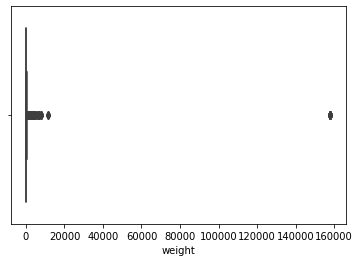

In [ ]:
sns.boxplot(x=df["weight"])

In [ ]:
test['weight'].describe()

count    4.000000e+06
mean     2.399753e+02
std      3.967060e+02
min      0.000000e+00
25%      5.200000e+01
50%      1.050000e+02
75%      2.650000e+02
max      1.580000e+05
Name: weight, dtype: float64

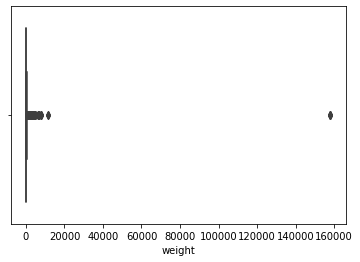

In [ ]:
sns.boxplot(x=test["weight"])

### mailtype

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 32 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     float64
 2   type                           object 
 3   priority                       float64
 4   is_privatecategory             object 
 5   class                          float64
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         float64
 9   mailtype                       object 
 10  mailctg                        float64
 11  directctg                      float64
 12  transport_pay                  float64
 13  postmark                       float64
 14  name_mfi                       object 
 15  weight_mfi                     float64
 16  price_mfi                      float64
 17  dist_qty_oper_login_1          float64
 18  to

In [ ]:
df['mailtype'].value_counts()

5.0    5992702
0.0       5239
2.0       1470
7.0        462
4.0         84
1.0         20
8.0         19
6.0          2
9.0          2
Name: mailtype, dtype: int64

In [ ]:
df['mailtype'] = df['mailtype'].apply(str)

In [ ]:
test['mailtype'].value_counts()

5.0    3995066
0.0       3453
2.0        969
7.0        336
4.0         47
1.0         14
8.0         14
Name: mailtype, dtype: int64

In [ ]:
test['mailtype'] = test['mailtype'].apply(str)

### mailctg

In [ ]:
df['mailctg'].value_counts()

 1.0    4688163
 0.0    1257102
-1.0      54015
 3.0        546
 5.0         20
Name: mailctg, dtype: int64

In [ ]:
df['mailctg'] = df['mailctg'].apply(str)

In [ ]:
test['mailctg'].value_counts()

 1.0    3127057
 0.0     836708
-1.0      35737
 3.0        383
 5.0         14
Name: mailctg, dtype: int64

In [ ]:
test['mailctg'] = test['mailctg'].apply(str)

### mailrank

In [ ]:
df['mailrank'].value_counts()

0.0    6000000
Name: mailrank, dtype: int64

In [ ]:
test['mailrank'].value_counts()

0.0    4000000
Name: mailrank, dtype: int64

In [ ]:
df = df.drop('mailrank', axis=1)

In [ ]:
test = test.drop('mailrank', axis=1)

### directctg

In [ ]:
df['directctg'].value_counts()

2.0    5930331
1.0      69360
0.0        155
Name: directctg, dtype: int64

In [ ]:
df['directctg'] = df['directctg'].apply(str)

In [ ]:
test['directctg'].value_counts()

2.0    3953624
1.0      46169
0.0        106
Name: directctg, dtype: int64

In [ ]:
test['directctg'] = test['directctg'].apply(str)

### transport_pay

In [ ]:
df['transport_pay'].describe()

count    5.999846e+06
mean     1.187680e+01
std      2.224817e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.295000e+01
max      8.305000e+02
Name: transport_pay, dtype: float64

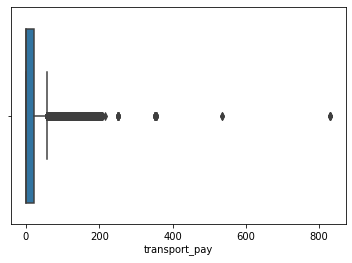

In [ ]:
sns.boxplot(x=df["transport_pay"])

In [ ]:
test['transport_pay'].describe()

count    3.999899e+06
mean     1.187999e+01
std      2.224371e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.291000e+01
max      8.305000e+02
Name: transport_pay, dtype: float64

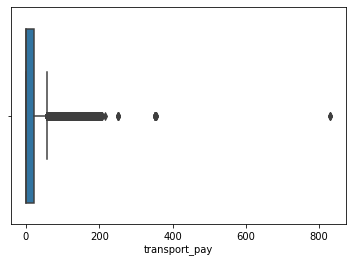

In [ ]:
sns.boxplot(x=test["transport_pay"])

### postmark

In [ ]:
df['postmark'].value_counts()

0.0       5998832
512.0         901
1024.0         79
8.0            23
256.0           7
1.0             4
Name: postmark, dtype: int64

In [ ]:
df['postmark'] = df['postmark'].apply(str)

In [ ]:
test['postmark'].value_counts()

0.0       3999187
512.0         622
1024.0         67
8.0            15
256.0           4
1.0             4
Name: postmark, dtype: int64

In [ ]:
test['postmark'] = test['postmark'].apply(str)

### name_mfi

In [ ]:
df['name_mfi'].value_counts()

0                                                                           815434
Mobile Phone Bags & Cases                                                    48165
Screen Protectors                                                            45032
phone case                                                                   42696
Phone Case                                                                   25031
                                                                             ...  
BRUSH(X-DZS-2inch)                                                               1
car led light(b-ty-highlander-15/18)                                             1
iPhone glass(1005001915468400)                                                   1
Tops,Women_s Jacket/T shirt,Women's Jacket/T shirt                               1
Piston Rings PR-PW60-2SET(PR-PW60-2SET),Piston Rings PR-PW60-2SET(PR-PW6         1
Name: name_mfi, Length: 212936, dtype: int64

In [ ]:
test['name_mfi'].value_counts()

0                                                                             544856
phone case                                                                     50498
mobile phone bags & cases                                                      32122
screen protectors                                                              30161
necklace                                                                       19329
                                                                               ...  
watchbands dsb10011l58                                                             1
tg1711                                                                             1
mp4accessories mx245581_03 a5b 0 mp4accessories mx245581_03 a5b 08b3 02*1          1
cross stitch kits s14k608                                                          1
phone case ys001 i11 a                                                             1
Name: name_mfi, Length: 195300, dtype: int64

In [ ]:
def text_prep(text):
  new_text = text.lower()
  new_text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", " ", new_text)

  return new_text

In [ ]:
df['name_mfi'] = df['name_mfi'].apply(text_prep)

In [ ]:
test['name_mfi'] = test['name_mfi'].apply(text_prep)

In [ ]:
morph_eng = WordNetLemmatizer()

def lemmatize_eng(doc):
    j=''
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph_eng.lemmatize(token)
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j

In [ ]:
df['name_lemm'] = df['name_mfi'].apply(lemmatize_eng)

In [ ]:
test['name_lemm'] = test['name_mfi'].apply(lemmatize_eng)

In [ ]:
df[['name_lemm', 'name_mfi']]

,name_lemm,name_mfi
0,fishhook usb,fishhook usb
1,screen protector case q613b case 208b40 db,screen protector case q613b case 208b40 db
2,pendant necklace ring woman necklace,pendant necklaces rings for women necklaces
3,motorcycle signal lamp,motorcycle signal lamp
4,backpack,backpack
...,...,...
5999995,key chain,key chain
5999996,doll,dolls
5999997,jacket,down jacket
5999998,0,0


In [ ]:
df.to_pickle('df.pkl')

In [ ]:
test.to_pickle('test.pkl')

In [ ]:
!cp 'df.pkl' '/content/drive/MyDrive/post/'

In [ ]:
!cp 'test.pkl' '/content/drive/MyDrive/post/'

### weight_mfi

In [ ]:
df['weight_mfi'].describe()

count    6.000000e+06
mean     1.236553e+02
std      2.084230e+02
min      0.000000e+00
25%      2.300000e+01
50%      6.000000e+01
75%      1.230000e+02
max      1.800000e+04
Name: weight_mfi, dtype: float64

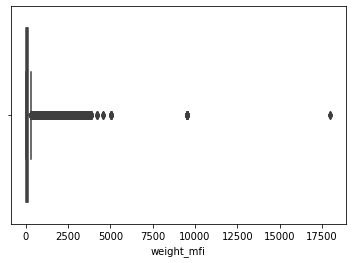

In [ ]:
sns.boxplot(x=df["weight_mfi"])

In [ ]:
test['weight_mfi'].describe()

count    4.000000e+06
mean     1.237179e+02
std      2.093481e+02
min      0.000000e+00
25%      2.300000e+01
50%      6.000000e+01
75%      1.230000e+02
max      1.800000e+04
Name: weight_mfi, dtype: float64

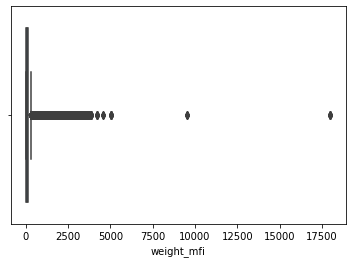

In [ ]:
sns.boxplot(x=test["weight_mfi"])

### price_mfi

In [ ]:
df['price_mfi'].describe()

count    5.999846e+06
mean     4.561017e+02
std      2.103316e+03
min      0.000000e+00
25%      5.000000e+01
50%      1.920000e+02
75%      4.180000e+02
max      1.597050e+05
Name: price_mfi, dtype: float64

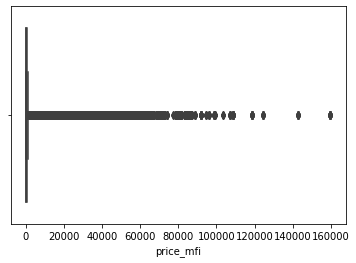

In [ ]:
sns.boxplot(x=df["price_mfi"])

In [ ]:
test['price_mfi'].describe()

count    3.999899e+06
mean     4.556003e+02
std      2.115309e+03
min      0.000000e+00
25%      5.000000e+01
50%      1.920000e+02
75%      4.190000e+02
max      1.597050e+05
Name: price_mfi, dtype: float64

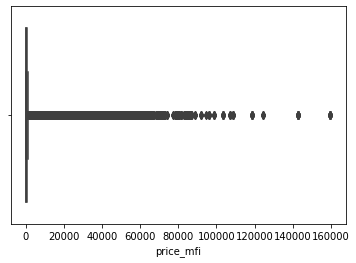

In [ ]:
sns.boxplot(x=test['price_mfi'])

### dist_qty_oper_login_1 

In [ ]:
df['dist_qty_oper_login_1'].describe()

count    5.999846e+06
mean     3.190768e+02
std      4.012515e+02
min      0.000000e+00
25%      3.100000e+01
50%      1.130000e+02
75%      9.140000e+02
max      1.142000e+03
Name: dist_qty_oper_login_1, dtype: float64

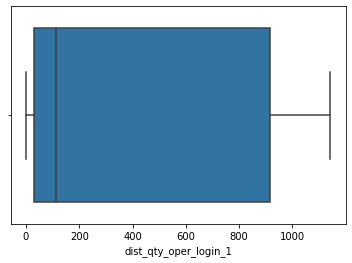

In [ ]:
sns.boxplot(x=df['dist_qty_oper_login_1'])

In [ ]:
test['dist_qty_oper_login_1'].describe()

count    3.999899e+06
mean     3.189433e+02
std      4.012009e+02
min      0.000000e+00
25%      3.100000e+01
50%      1.130000e+02
75%      9.140000e+02
max      1.142000e+03
Name: dist_qty_oper_login_1, dtype: float64

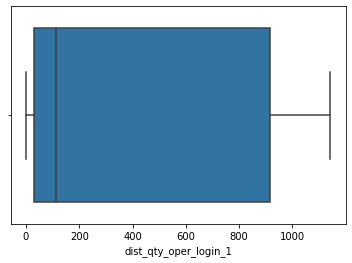

In [ ]:
sns.boxplot(x=test['dist_qty_oper_login_1'])

### total_qty_oper_login_1

In [ ]:
df['total_qty_oper_login_1'].describe()

count    5.999846e+06
mean     2.775162e+07
std      2.903662e+07
min      0.000000e+00
25%      1.113900e+06
50%      9.570832e+06
75%      5.610820e+07
max      1.416888e+08
Name: total_qty_oper_login_1, dtype: float64

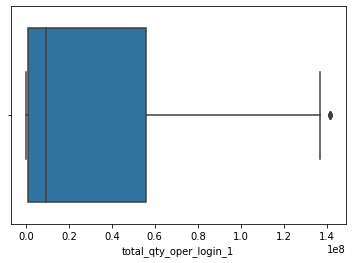

In [ ]:
sns.boxplot(x=df['total_qty_oper_login_1'])

In [ ]:
test['total_qty_oper_login_1'].describe()

count    3.999899e+06
mean     2.773728e+07
std      2.903665e+07
min      0.000000e+00
25%      1.113748e+06
50%      9.570832e+06
75%      5.610820e+07
max      1.416888e+08
Name: total_qty_oper_login_1, dtype: float64

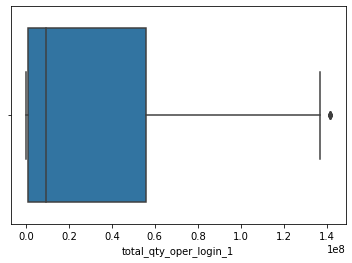

In [ ]:
sns.boxplot(x=test['total_qty_oper_login_1'])

### total_qty_oper_login_0

In [ ]:
df['total_qty_oper_login_0'].describe()

count    5.999846e+06
mean     2.898961e+07
std      5.334310e+07
min      0.000000e+00
25%      1.064800e+04
50%      3.664710e+05
75%      8.331893e+07
max      4.156581e+08
Name: total_qty_oper_login_0, dtype: float64

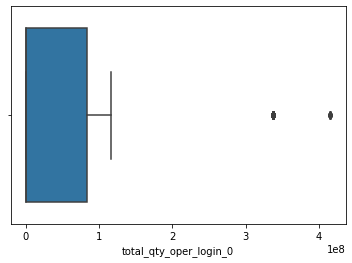

In [ ]:
sns.boxplot(x=df['total_qty_oper_login_0'])

In [ ]:
test['total_qty_oper_login_0'].describe()

count    3.999899e+06
mean     2.897445e+07
std      5.333971e+07
min      0.000000e+00
25%      1.064800e+04
50%      3.664710e+05
75%      8.331893e+07
max      4.156581e+08
Name: total_qty_oper_login_0, dtype: float64

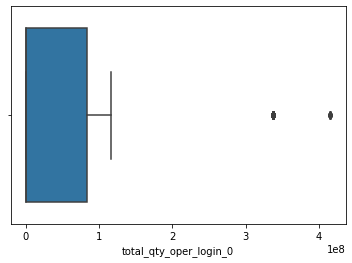

In [ ]:
sns.boxplot(x=test['total_qty_oper_login_0'])

### total_qty_over_index_and_type

In [ ]:
df['total_qty_over_index_and_type'].describe()

count    5.999846e+06
mean     5.674123e+07
std      7.290428e+07
min      0.000000e+00
25%      1.673370e+06
50%      1.393496e+07
75%      1.321756e+08
max      4.897385e+08
Name: total_qty_over_index_and_type, dtype: float64

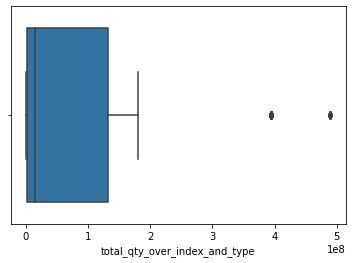

In [ ]:
sns.boxplot(x=df['total_qty_over_index_and_type'])

In [ ]:
test['total_qty_over_index_and_type'].describe()

count    3.999899e+06
mean     5.671173e+07
std      7.290413e+07
min      0.000000e+00
25%      1.656011e+06
50%      1.393496e+07
75%      1.321756e+08
max      4.897385e+08
Name: total_qty_over_index_and_type, dtype: float64

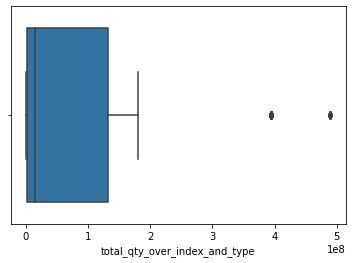

In [ ]:
sns.boxplot(x=test['total_qty_over_index_and_type'])

### total_qty_over_index

In [ ]:
df['total_qty_over_index'].describe()

count    5.999846e+06
mean     7.178866e+07
std      7.509282e+07
min      0.000000e+00
25%      1.040204e+07
50%      5.270807e+07
75%      1.368198e+08
max      5.002511e+08
Name: total_qty_over_index, dtype: float64

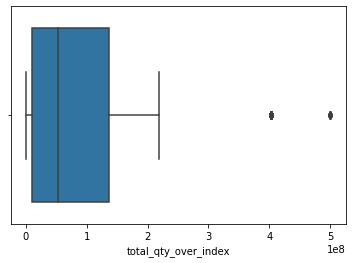

In [ ]:
sns.boxplot(x=df['total_qty_over_index'])

In [ ]:
test['total_qty_over_index'].describe()

count    3.999899e+06
mean     7.177323e+07
std      7.509604e+07
min      0.000000e+00
25%      1.040204e+07
50%      5.270807e+07
75%      1.368198e+08
max      5.002511e+08
Name: total_qty_over_index, dtype: float64

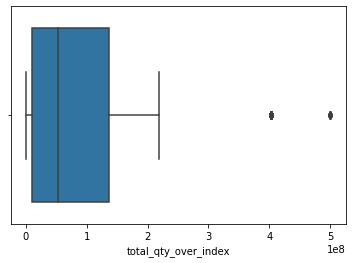

In [ ]:
sns.boxplot(x=test['total_qty_over_index'])

### is_wrong_sndr_name

In [ ]:
df['is_wrong_sndr_name'].value_counts()

0    5984461
1      15385
Name: is_wrong_sndr_name, dtype: int64

In [ ]:
df['is_wrong_sndr_name'] = df['is_wrong_sndr_name'].apply(str)

In [ ]:
test['is_wrong_sndr_name'].value_counts()

0    3989568
1      10331
Name: is_wrong_sndr_name, dtype: int64

In [ ]:
test['is_wrong_sndr_name'] = test['is_wrong_sndr_name'].apply(str)

### is_wrong_rcpn_name

In [ ]:
df['is_wrong_rcpn_name'].value_counts()

0    4441280
1    1558566
Name: is_wrong_rcpn_name, dtype: int64

In [ ]:
df['is_wrong_rcpn_name'] = df['is_wrong_rcpn_name'].apply(str)

In [ ]:
test['is_wrong_rcpn_name'].value_counts()

0    2960767
1    1039132
Name: is_wrong_rcpn_name, dtype: int64

In [ ]:
test['is_wrong_rcpn_name'] = test['is_wrong_rcpn_name'].apply(str)

### is_wrong_phone_number

In [ ]:
df['is_wrong_phone_number'].value_counts()

0    4974030
1    1025816
Name: is_wrong_phone_number, dtype: int64

In [ ]:
df['is_wrong_phone_number'] = df['is_wrong_phone_number'].apply(str)

In [ ]:
test['is_wrong_phone_number'].value_counts()

0    3316923
1     682976
Name: is_wrong_phone_number, dtype: int64

In [ ]:
test['is_wrong_phone_number'] = test['is_wrong_phone_number'].apply(str)

### is_wrong_address

In [ ]:
df['is_wrong_address'].value_counts()

0    5992269
1       7577
Name: is_wrong_address, dtype: int64

In [ ]:
df['is_wrong_address'] = df['is_wrong_address'].apply(str)

In [ ]:
test['is_wrong_address'].value_counts()

0    3994953
1       4946
Name: is_wrong_address, dtype: int64

In [ ]:
test['is_wrong_address'] = test['is_wrong_address'].apply(str)

### label

In [ ]:
df['label'].value_counts()

0    5828866
1     170980
Name: label, dtype: int64

In [ ]:
df.to_pickle('df.pkl')

In [ ]:
test.to_pickle('test.pkl')

In [ ]:
from google.colab import files


In [ ]:
!cp 'df.pkl' '/content/drive/MyDrive/post/'

In [ ]:
!cp 'test.pkl' '/content/drive/MyDrive/post/'

## Предсказание по текстовой фиче

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/post/df.pkl")

In [ ]:
test = pd.read_pickle("/content/drive/My Drive/post/test.pkl")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999846 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     object 
 2   type                           object 
 3   priority                       float64
 4   is_privatecategory             object 
 5   class                          float64
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         float64
 9   mailtype                       float64
 10  mailctg                        float64
 11  directctg                      float64
 12  transport_pay                  float64
 13  postmark                       float64
 14  name_mfi                       object 
 15  weight_mfi                     float64
 16  price_mfi                      float64
 17  dist_qty_oper_login_1          float64
 18  to

In [ ]:
df['name_mfi_len']=df['name_mfi'].apply(lambda x:len(x.split()))
test['name_mfi_len']=test['name_mfi'].apply(lambda x:len(x.split()))

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df['name_mfi'])
X_test = vectorizer.transform(test['name_mfi'])

In [ ]:
%%time
trans = Normalizer()
X_train_len=trans.fit_transform(df['name_mfi_len'].values.reshape(-1,1))
X_test_len=trans.transform(test['name_mfi_len'].values.reshape(-1,1))

CPU times: user 93.6 ms, sys: 842 µs, total: 94.5 ms
Wall time: 89.2 ms


In [ ]:
%%time
train_s=hstack((X_train,X_train_len))
test_s=hstack((X_test,X_test_len))

CPU times: user 904 ms, sys: 5.98 ms, total: 910 ms
Wall time: 909 ms


In [ ]:
y = df[['label']]

In [ ]:
print(train_s.shape,y.shape)
print(test_s.shape)

(5999846, 97422) (5999846, 1)
(4000000, 97422)


In [ ]:
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}

In [ ]:
model = LGBMClassifier(random_state=42)
model.fit(train_s, y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(random_state=42)

In [ ]:
first_pred_1 = model.predict_proba(train_s)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [ ]:
first_pred_1[:, 0]

array([0.9731669 , 0.97856533, 0.97287654, ..., 0.9795477 , 0.97348808,
       0.97342184])

In [ ]:
first_pred_1[:, 1]

array([0.0268331 , 0.02143467, 0.02712346, ..., 0.0204523 , 0.02651192,
       0.02657816])

In [ ]:
df['first_pred_1'] = first_pred_1[:, 0]
df['first_pred_2'] = first_pred_1[:, 1]


In [ ]:
test_pred_1 = model.predict_proba(test_s)

In [ ]:
test['first_pred_1'] = test_pred_1[:, 0]
test['first_pred_2'] = test_pred_1[:, 1]

In [ ]:
df.to_pickle('df.pkl')

In [ ]:
test.to_pickle('test.pkl')

In [ ]:
!cp 'df.pkl' '/content/drive/MyDrive/post/'

In [ ]:
!cp 'test.pkl' '/content/drive/MyDrive/post/'

## ML

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_pickle("/content/drive/My Drive/post/df.pkl")

In [ ]:
test = pd.read_pickle("/content/drive/My Drive/post/test.pkl")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             int64  
 6   class                          float64
 7   is_in_yandex                   int64  
 8   is_return                      int64  
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

In [ ]:
df = df.drop(['name_lemm', 'oper_type + oper_attr'], axis=1)

In [ ]:
test = test.drop(['name_lemm', 'oper_type + oper_attr'], axis=1)

In [ ]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,0,0.0,1,0,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,0,0.0,0,0,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,0,0.0,1,0,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,0,0.0,1,0,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,0,0.0,1,0,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [ ]:
test.head()

,id,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,oper_type,oper_attr,name_mfi_len,first_pred_1
0,7815282,102976.0,ММПО,7503.0,0,0.0,0,0,85.0,5.0,...,159889293.0,164927295.0,0,0,0,0,8,13,4,0.986382
1,8443555,238753.0,ГОПС,7503.0,0,4.0,1,0,21.0,5.0,...,4440.0,20623.0,0,1,1,0,8,2,3,0.973488
2,6352559,618254.0,ГОПС,7503.0,0,4.0,1,0,388.0,5.0,...,3744.0,37817.0,0,0,0,0,1020,-1,1,0.979799
3,4921420,102968.0,ТИ,7503.0,0,0.0,0,0,1203.0,5.0,...,11646942.0,11759329.0,0,1,0,0,1016,-1,1,0.973488
4,1420440,102971.0,Цех,7506.0,0,0.0,0,0,956.0,5.0,...,76146936.0,84110459.0,0,1,0,0,1018,-1,3,0.981638


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             int64  
 6   class                          float64
 7   is_in_yandex                   int64  
 8   is_return                      int64  
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  name_mfi                       object 
 16  weight_mfi                     float64
 17  price_mfi                      float64
 18  di

In [ ]:
df['first_pred_1'].describe()

count    6.000000e+06
mean     9.715020e-01
std      9.850528e-03
min      4.361464e-01
25%      9.704499e-01
50%      9.734881e-01
75%      9.747157e-01
max      9.941265e-01
Name: first_pred_1, dtype: float64

In [ ]:
X = df.drop(['label'], axis = 1)
y = df["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [ ]:
cat_features = ['type', 'oper_type', 'oper_attr', 'index_oper', 'name_mfi']
text_features = ['name_mfi']

In [ ]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

In [ ]:
model_cat = CatBoostClassifier(random_state=42, class_weights=class_weights, task_type="GPU", cat_features=cat_features, iterations=500)

In [ ]:
model_cat.fit(X_train, y_train)

Learning rate set to 0.039648
0:	learn: 0.6094409	total: 554ms	remaining: 4m 36s
1:	learn: 0.5385367	total: 1.13s	remaining: 4m 40s
2:	learn: 0.4810099	total: 1.68s	remaining: 4m 37s
3:	learn: 0.4300369	total: 2.21s	remaining: 4m 33s
4:	learn: 0.3864247	total: 2.74s	remaining: 4m 30s
5:	learn: 0.3498167	total: 3.28s	remaining: 4m 30s
6:	learn: 0.3194942	total: 3.77s	remaining: 4m 25s
7:	learn: 0.2931966	total: 4.3s	remaining: 4m 24s
8:	learn: 0.2671016	total: 4.84s	remaining: 4m 23s
9:	learn: 0.2466440	total: 5.39s	remaining: 4m 24s
10:	learn: 0.2282486	total: 5.85s	remaining: 4m 19s
11:	learn: 0.2126170	total: 6.41s	remaining: 4m 20s
12:	learn: 0.2001489	total: 6.98s	remaining: 4m 21s
13:	learn: 0.1893499	total: 7.53s	remaining: 4m 21s
14:	learn: 0.1798998	total: 8.06s	remaining: 4m 20s
15:	learn: 0.1716751	total: 8.61s	remaining: 4m 20s
16:	learn: 0.1636387	total: 9.15s	remaining: 4m 20s
17:	learn: 0.1564247	total: 9.66s	remaining: 4m 18s
18:	learn: 0.1506103	total: 10.3s	remaining: 

## Оценка точности

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
df_valid_pred = model_cat.predict(X_test)

In [ ]:
recall_score(y_test, df_valid_pred, average = "macro" )

0.9781614839570836

## Результат

In [ ]:
df_test_pred = model_cat.predict(test)

In [ ]:
df_sub = pd.read_csv('/content/drive/My Drive/post/sample_solution.csv')

In [ ]:
df_sub


,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,0
3999996,6275048,0
3999997,4701757,0
3999998,611153,0


In [ ]:
df_sub["label"] = df_test_pred
df_sub.head()

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0


In [ ]:
df_sub["label"].value_counts()

0    3730578
1     269422
Name: label, dtype: int64

In [ ]:
df_sub.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   label   int64
dtypes: int64(2)
memory usage: 61.0 MB


In [ ]:
df_sub.to_csv("/content/submission.csv", index = False)

In [ ]:
model_cat.get_feature_importance(prettified=True)



,Feature Id,Importances
0,oper_type,31.617999
1,total_qty_oper_login_0,13.944979
2,index_oper,9.402478
3,dist_qty_oper_login_1,5.756536
4,mailctg,4.657424
5,total_qty_oper_login_1,4.601431
6,oper_attr,4.395848
7,total_qty_over_index_and_type,4.364568
8,total_qty_over_index,3.809815
9,transport_pay,3.056953
